# IP를 이용한 훼손 영역에 대한 검출 가능성 보이기

## 1. 모델 설계

모델은 다음의 3가지 과정을 거친다.

> 색공간 변경 -> 임계처리 -> 모폴로지

In [1]:
import numpy as np
import cv2

# --------------------------------

def convertColorSpace(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

def threshold(frame):
    # HSV 색공간을 이용. 채도와 밝기가 낮은 곳을 선택함. (==그림자)
    range_lower = (  0,  0,  0)
    range_upper = (255, 96, 92)
    return cv2.inRange(frame, range_lower, range_upper)

def morphology(frame_bin):
    frame_bin = cv2.morphologyEx(frame_bin, cv2.MORPH_CLOSE, (5,5))
    return cv2.morphologyEx(frame_bin, cv2.MORPH_OPEN, (5,5))

# --------------------------------

def sequence(layers):
    def inner(x):
        retval = x
        for proc in layers:
            retval = proc(retval)
        return retval
    return inner

# --------------------------------

model = sequence([
    convertColorSpace,
    threshold,
    morphology
])

# --------------------------------

original = cv2.imread('data/source/partial_01.JPG')
result   = model(original)

## 2. 결과 출력

위 셀에서 얻은 결과 `result`와 원본 이미지를 비교 출력한다.

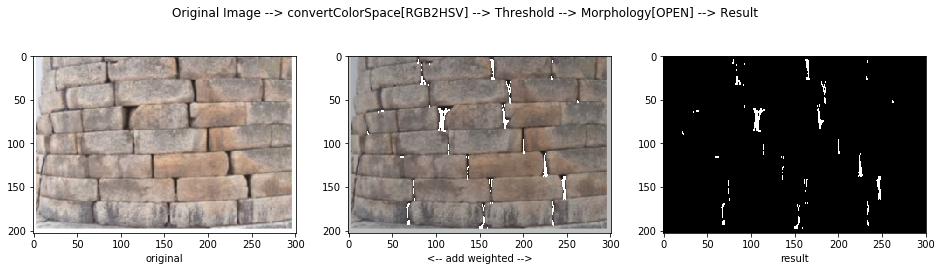

In [2]:
# 위 코드에 이어서...

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(16,4))
fig.suptitle('Original Image --> convertColorSpace[RGB2HSV] --> Threshold --> Morphology[OPEN] --> Result')

# Plot 0
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_xlabel('original')

# Plot 1
added_result = cv2.addWeighted(original, 0.75, cv2.cvtColor(result, cv2.COLOR_GRAY2BGR), 1, 0)
axs[1].imshow(cv2.cvtColor(added_result, cv2.COLOR_BGR2RGB))
axs[1].set_xlabel('<-- add weighted -->')

# Plot 2
axs[2].imshow(result, cmap='gray')
axs[2].set_xlabel('result')

plt.show()

## 3. 훼손 영역 검출

앞선 과정들에서 얻은 결과 `result`에는 **(균열로 인하여 생긴) 그림자에 대한 마스크 이미지**가 담겨있다.  
  
다음 코드에서는 1. 이들에 대한 윤곽선을 검출하고, 2. 그 넓이에 임계치를 주어 훼손된 영역인지를 가린다.

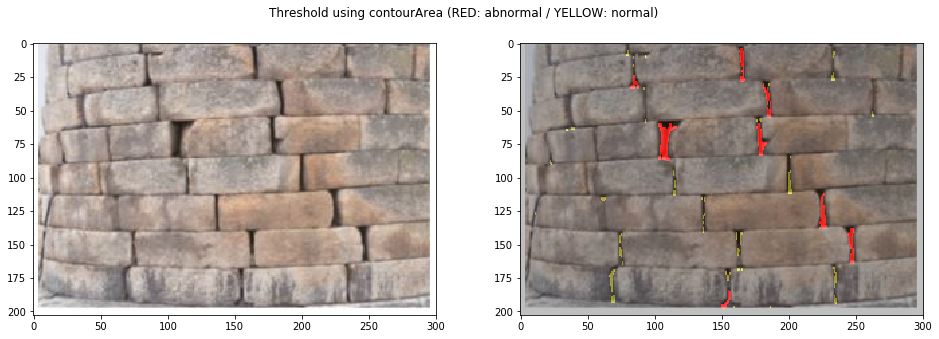

In [3]:
# 위 코드에 이어서...

MIN_CONT_AREA = 20

# --------------------------------

def contourAreaThreshold(frame_bin):
    # 윤곽선 면적에도 임계를 주어 훼손여부를 가림.
    colored_mask = cv2.cvtColor(frame_bin, cv2.COLOR_GRAY2BGR)

    for contour in cv2.findContours(frame_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]:
        # 임계치를 넘는다면, 붉은 색으로 처리: 훼손된 영역
        if (cv2.contourArea(contour) >= MIN_CONT_AREA):
            cv2.drawContours(colored_mask, [contour], -1, (0,0,255), -1)

        # 임계치를 넘지 못한다면, (반투명)노란색으로 처리
        else:
            cv2.drawContours(colored_mask, [contour], -1, (0,128,128), -1)

    return colored_mask

# --------------------------------

colored_result = contourAreaThreshold(result)

colored_original = cv2.addWeighted(original, 0.75, colored_result, 0.75, 0)

# --------------------------------

fig, axs = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Threshold using contourArea (RED: abnormal / YELLOW: normal)')

axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(colored_original, cv2.COLOR_BGR2RGB))

plt.show()

## 4. 다음 연구로의 데이터 전달

* 연구 노트: [2_정상-비정상-머신러닝적용.ipynb](./2_%EC%A0%95%EC%83%81-%EB%B9%84%EC%A0%95%EC%83%81-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%A0%81%EC%9A%A9.ipynb)

In [4]:
# 원본 (original)
model_0 = sequence([
        cv2.imread
    ])

# 마스크 이미지 (mask)
model_1 = sequence([
        cv2.imread,
        convertColorSpace,
        threshold,
        morphology
    ])

# 마스크 이미지 - 임계처리 (mask-colored)
model_2 = sequence([
        cv2.imread,
        convertColorSpace,
        threshold,
        morphology,
        contourAreaThreshold
    ])

In [5]:
import os

output_path = "data/tmp"

file_path_list = [
    'data/source/partial_01.JPG',
    'data/source/partial_p_01.JPG',
    'data/source/total_01.JPG'
]

# --------------------------------

if not os.path.exists(output_path): os.mkdir(output_path)

for file_path in file_path_list:
    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    cv2.imwrite(os.path.join(output_path, f"{file_name}{file_extension}"),              model_0(file_path))
    cv2.imwrite(os.path.join(output_path, f"{file_name}_mask{file_extension}"),         model_1(file_path))
    cv2.imwrite(os.path.join(output_path, f"{file_name}_mask-colored{file_extension}"), model_2(file_path))

with open(os.path.join(output_path, ".datalist"), "w") as f:
    f.write('\n'.join([os.path.basename(file_path) for file_path in file_path_list]))